# Intel Image Classification - Pytorch CNN + Data Augmentation Techniques

### 1. Preparación del entorno

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import PIL

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, dataset

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder


Descargo Dataset desde Kaggle

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")




c:\Users\juanq\Desktop\repo\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reviso si tengo disponible GPU

In [3]:
try:
    # En torchvision>=0.15 existe transforms.v2; aquí usamos el API clásico para compatibilidad
    _ = transforms.Compose
except Exception as e:
    raise RuntimeError("Se requiere torchvision con 'transforms'.")

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

### 2. Cargar y visualizar las Ímagenes

Visualizar imagenes cargadas

In [10]:
img = PIL.Image.open("dataset/seg_pred/61.jpg")
img.show()

Utilizar dataloader para cargar las imágenes en lotes de 4

Clases detectadas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Número total de imágenes: 14034


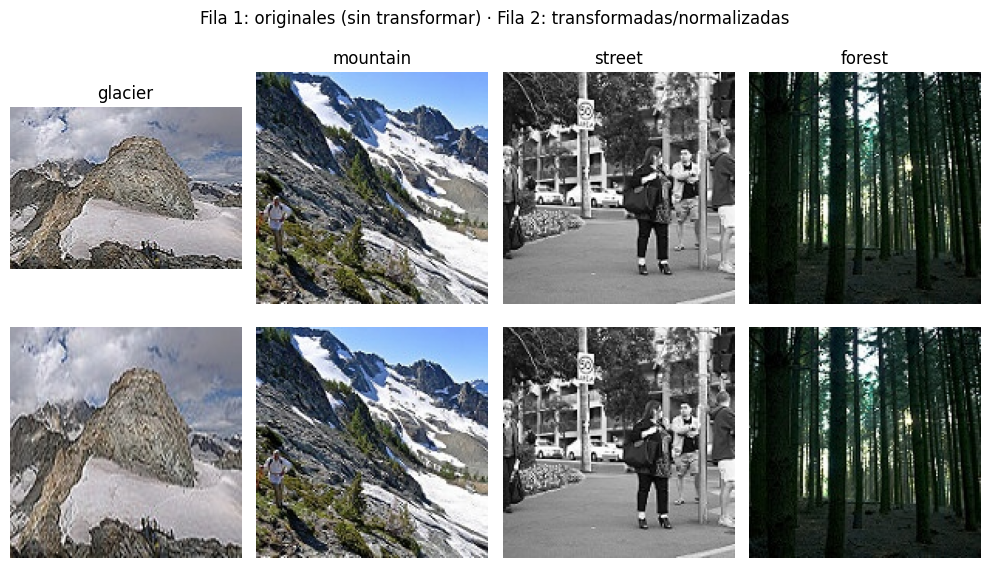

In [25]:
DATA_DIR = "dataset/seg_train/seg_train/"

IMG_SIZE = 150
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]



#Transformación para la visualización

tfm_plain = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

train_ds_plain = ImageFolder(DATA_DIR, transform=tfm_plain)
class_names = train_ds_plain.classes
print("Clases detectadas:", class_names)
print("Número total de imágenes:", len(train_ds_plain))


batch_size = 4

loader = DataLoader(train_ds_plain,batch_size=batch_size, shuffle = True, num_workers = 0)


# 4) Función para desnormalizar (para mostrar colores correctos)
def denormalize(img_tensor, mean, std):
    m = torch.tensor(mean).view(3, 1, 1)
    s = torch.tensor(std).view(3, 1, 1)
    return img_tensor * s + m

# 5) Tomar un lote y visualizar
images, labels = next(iter(loader))


    

# --- Dataset SIN transformar (PIL, tamaños originales) ---
train_ds_raw = ImageFolder(DATA_DIR)  # sin transform

# Elige N índices (los mismos para raw y plain)
N = 4  # o usa batch_size
indices = torch.randperm(len(train_ds_plain))[:N].tolist()

# Recupera pares (raw vs transformada) con los mismos índices
raw_imgs, raw_labels = [], []
aug_imgs, aug_labels = [], []

for idx in indices:
    pil_img, y_raw = train_ds_raw[idx]       # PIL (sin transformar)
    ten_img, y_aug = train_ds_plain[idx]     # Tensor (con transformar/normalizar)
    raw_imgs.append(pil_img)
    raw_labels.append(y_raw)
    aug_imgs.append(ten_img)
    aug_labels.append(y_aug)

# --- Visualización: fila 1 originales (raw), fila 2 transformadas ---
plt.figure(figsize=(10, 6))
plt.suptitle("Fila 1: originales (sin transformar) · Fila 2: transformadas/normalizadas")

# Fila 1: originales (PIL)
for i in range(N):
    ax = plt.subplot(2, N, i + 1)
    ax.imshow(raw_imgs[i])  # PIL directamente
    ax.set_title(class_names[raw_labels[i]])
    ax.axis("off")

# Fila 2: transformadas (Tensor normalizado -> desnormalizamos para ver bien los colores)
for i in range(N):
    ax = plt.subplot(2, N, N + i + 1)
    img = denormalize(aug_imgs[i], mean, std).permute(1, 2, 0).numpy()
    ax.imshow(np.clip(img, 0, 1))
    ax.axis("off")

plt.tight_layout()
plt.show()

Defino las transformaciones

In [26]:
aug_list = [
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.RandomGrayscale(p=0.1),
]
try:
    aug_list.append(transforms.GaussianBlur(kernel_size=3))
except Exception:
    pass

tfm_aug = transforms.Compose(aug_list + [
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])